# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
%matplotlib inline

# Importing libraries for pyspark
from pyspark.ml import pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LinearSVC, NaiveBayes,RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import CountVectorizer, IDF, StopWordsRemover, StringIndexer, Normalizer, RegexTokenizer, StandardScaler, VectorAssembler, PCA
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import rank 
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col 
from pyspark.sql.functions import sort_array, asc, avg
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import stddev as Fstddev
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler



# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split# Split the data into training and testing sets


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
mysparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(mysparkify_data)

In [4]:
### View first 5 observations
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
### Get the number of rows and columns
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))

The number of rows in the dataframe is 286500
The number of columns in the dataframe is 18


In [6]:
# Drop observations with missing user id or session id
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [7]:
# Drop any observations that has an empty string in userId
df = df[df.userId != ""]
df.count()

278154

In [8]:
# Showing the first 25 values for 'userid'
df.select('userId').dropDuplicates().sort('userId').show(25)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
|100019|
|100021|
|100022|
|100023|
|100024|
+------+
only showing top 25 rows



In [9]:
df.describe().show()

+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|     auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|   278154|   278154|278154|            278154|  278154|           228108|278154|           278154|278154| 278154|             

In [10]:
# Converting spark dataframe to pandas dataframe and displaying the top 5 cells using head function
new_df = df.toPandas()
new_df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [11]:
### Frequency count for 'userid'
new_df['userId'].value_counts()

39        9632
92        7230
140       6880
300011    5732
124       4825
300021    4659
300017    4428
85        4370
42        4257
200023    3769
6         3761
29        3603
54        3437
100       3214
9         3191
126       3102
300015    3051
91        3014
98        2891
74        2887
118       2868
136       2567
65        2544
138       2469
88        2465
51        2464
4         2442
97        2404
81        2335
132       2304
          ... 
300007     143
144        125
154        118
72         117
57         112
32         108
63         107
300024     102
84          97
100019      89
200012      84
116         79
100003      78
200007      76
100017      75
34          73
64          68
122         62
134         52
68          48
90          45
100006      44
133         44
22          40
100024      36
300003      35
100011      23
125         11
156          6
135          6
Name: userId, Length: 225, dtype: int64

In [12]:
# creating new columns by clearly representing registration and timestamp  
new_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df = df.withColumn('updated_registration', new_ts('registration'))
df = df.withColumn('updated_ts', new_ts('ts'))

In [13]:
downgrade_value  = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgrade_value", downgrade_value("page"))

# find all users who downgraded
dg_window = Window.partitionBy('UserId')
df = df.withColumn("user_downgrade", max('downgrade_value').over(dg_window))

# define a churn label
churn_value = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churn_value", churn_value("page"))

# find all users who churned
churn_window = Window.partitionBy('UserId')
df = df.withColumn("user_churn", max('churn_value').over(churn_window))

# selecting few users to see
df.select(['userId', 'firstName', 'level','updated_ts','user_churn', 'user_downgrade']).dropDuplicates(subset = ['userId']).show(10)

+------+---------+-----+-------------------+----------+--------------+
|userId|firstName|level|         updated_ts|user_churn|user_downgrade|
+------+---------+-----+-------------------+----------+--------------+
|100010| Darianna| free|10-08-2018 12:58:54|         0|             0|
|200002|  Dominic| free|10-01-2018 11:30:30|         0|             0|
|   125|    Mason| free|10-12-2018 04:05:44|         1|             0|
|   124|   Nicole| paid|10-01-2018 15:17:10|         0|             0|
|    51|    Ethan| paid|10-01-2018 12:57:12|         1|             0|
|     7|   Maddox| free|10-03-2018 11:57:49|         0|             0|
|    15|    Panav| paid|10-01-2018 10:23:35|         0|             0|
|    54|    Alexi| paid|10-01-2018 00:32:10|         1|             1|
|   155|   Camila| free|11-02-2018 15:56:25|         0|             0|
|100014|  Rodrigo| paid|10-10-2018 13:12:16|         1|             0|
+------+---------+-----+-------------------+----------+--------------+
only s

In [14]:
user_agg_churn = df.select(["userId", "user_churn"]) \
     .groupBy("userId") \
     .agg(Fsum('user_churn').alias('sum'))

In [15]:
print(user_agg_churn.filter(user_agg_churn["sum"] == 0).count())

173


In [16]:
print(user_agg_churn.filter(user_agg_churn["sum"] == 1).count())

0


In [17]:
user_agg_churn.filter(user_agg_churn["sum"] > 1).count()

52

In [18]:
# Get a list of all unique pages
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [19]:
# gender distribution between churn users and non-churner 
df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").show()

+----------+------+-----+
|user_churn|gender|count|
+----------+------+-----+
|         0|     M|   89|
|         0|     F|   84|
|         1|     F|   20|
|         1|     M|   32|
+----------+------+-----+



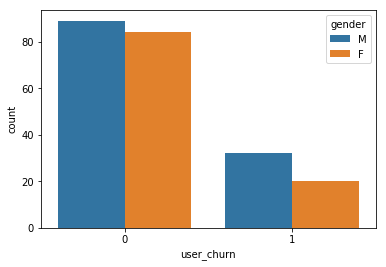

In [20]:
# Plotting this on a bar plot to show gender distribution between churners and non-churners
df_ch_pd = df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").toPandas()
sns.barplot(x = 'user_churn', y = 'count', data = df_ch_pd, hue = 'gender')

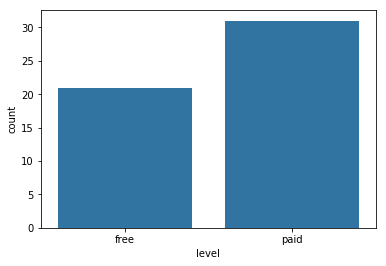

In [21]:
# Finding out which level customers churn more and plotting it
level_df = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
sns.barplot(data = level_df, x = 'level', y = 'count', color = sns.color_palette()[0])

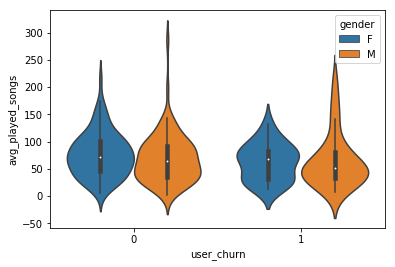

In [22]:
# Lets determine the gender distribution for number of songs played per session for churned and normal users
total_songs_df = df.where('page == "NextSong"').groupby(['user_churn', 'userId', 'sessionId', 'gender']).count()\
    .groupby(['user_churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'avg_played_songs').toPandas()

ax = sns.violinplot('user_churn', y = 'avg_played_songs', hue = 'gender', data = total_songs_df)

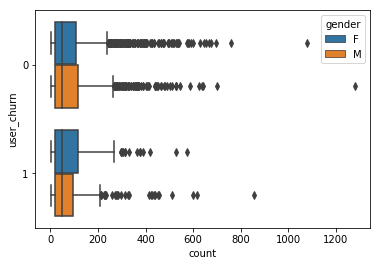

In [24]:
# Let's determine the gender distribution for total operations per session between normal and churned users
df_ops = df.groupby("user_churn", "userId", "sessionId", 'gender').count().toPandas()
sns.boxplot(x = 'count', y = 'user_churn', orient = 'horizontal', data = df_ops, hue = 'gender')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [25]:
# Feature 1 : Total number of  songs listened
feat_1 = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'tot_songs')
feat_1.show()

+------+---------+
|userId|tot_songs|
+------+---------+
|100010|      381|
|200002|      474|
|   125|       11|
|    51|     2464|
|   124|     4825|
|     7|      201|
|    54|     3437|
|    15|     2278|
|   155|     1002|
|   132|     2304|
|   154|      118|
|100014|      310|
|   101|     2149|
|    11|      848|
|   138|     2469|
|300017|     4428|
|    29|     3603|
|    69|     1342|
|100021|      319|
|    42|     4257|
+------+---------+
only showing top 20 rows



In [26]:
# Feature 2 : Number of thumbs up
feat_2 = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'tot_thumbs_up')
feat_2.show()

+------+-------------+
|userId|tot_thumbs_up|
+------+-------------+
|100010|           17|
|200002|           21|
|    51|          100|
|   124|          171|
|     7|            7|
|    54|          163|
|    15|           81|
|   155|           58|
|   132|           96|
|   154|           11|
|100014|           17|
|   101|           86|
|    11|           40|
|   138|           95|
|300017|          303|
|    29|          154|
|    69|           72|
|100021|           11|
|    42|          166|
|   112|            9|
+------+-------------+
only showing top 20 rows



In [27]:
# Feature 3 : Number of thumbs down
feat_3 = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'tot_thumbs_down')
feat_3.show()

+------+---------------+
|userId|tot_thumbs_down|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
|    15|             14|
|    54|             29|
|   155|              3|
|   132|             17|
|100014|              3|
|   101|             16|
|    11|              9|
|   138|             24|
|300017|             28|
|    29|             22|
|    69|              9|
|100021|              5|
|    42|             25|
|   112|              3|
|    73|              7|
+------+---------------+
only showing top 20 rows



In [28]:
# Feature 4 : Total time since registration
feat_4 = df.select('userId', 'registration', 'ts').withColumn('tot_lifetime', (df.ts - df.registration))\
    .groupBy('userId').agg({'tot_lifetime' : 'max'})\
    .withColumnRenamed('max(tot_lifetime)', 'tot_lifetime')\
    .select('userId', (col('tot_lifetime')/1000/3600/24).alias('tot_lifetime'))
feat_4.show()

+------+------------------+
|userId|      tot_lifetime|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
|   155|23.556018518518517|
|   132|  66.8891087962963|
|   154|23.872037037037035|
|100014| 85.08340277777778|
|   101|53.965937499999995|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|300017| 74.35851851851852|
|    29|60.104050925925925|
|    69| 71.42444444444445|
|100021| 64.73886574074074|
|    42| 67.11364583333334|
+------+------------------+
only showing top 20 rows



In [29]:
# Feature 5 : Total length of listening utilizing all services
feat_5 = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'tot_listen_time')
feat_5.show()

+------+------------------+
|userId|   tot_listen_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
|     7| 38034.08710000002|
|    54| 711344.9195400011|
|    15|477307.60581000015|
|   155|       198779.2919|
|   132| 483118.9038399997|
|   154|20660.023910000007|
|100014| 67703.47208000004|
|   101| 447464.0146699989|
|    11|159669.96303999983|
|   138| 512449.8827599989|
|300017| 897406.9802100015|
|    29| 754517.5625700009|
|    69| 286064.0256399999|
|100021| 57633.17563999999|
|    42| 881792.9661300007|
+------+------------------+
only showing top 20 rows



In [30]:
# Feature 6 : Total number of friends
feat_6 = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'tot_friends')
feat_6.show()

+------+-----------+
|userId|tot_friends|
+------+-----------+
|100010|          4|
|200002|          4|
|    51|         28|
|   124|         74|
|     7|          1|
|    54|         33|
|    15|         31|
|   155|         11|
|   132|         41|
|   154|          3|
|100014|          6|
|   101|         29|
|    11|          6|
|   138|         41|
|300017|         63|
|    29|         47|
|    69|         12|
|100021|          7|
|    42|         52|
|   112|          7|
+------+-----------+
only showing top 20 rows



In [31]:
# Feature 7 : Gender of the user
feat_7 = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
feat_7.show()

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
|    39|     0|
|100010|     0|
|    40|     0|
|    94|     0|
|    35|     0|
|    75|     0|
|   116|     0|
|200001|     1|
|200020|     1|
|100008|     0|
|200015|     1|
|   100|     1|
|100006|     0|
|300005|     0|
|    25|     0|
+------+------+
only showing top 20 rows



In [32]:
# Feature 8 : Total number of songs listened per session
feat_8  = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'avg_played_songs')

feat_8.show()

+------+------------------+
|userId|  avg_played_songs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



In [33]:
# Feature 9 : Total number of artists the user has listened to
feat_9 = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "tot_artist_played")
feat_9.show()

+------+-----------------+
|userId|tot_artist_played|
+------+-----------------+
|100010|              252|
|200002|              339|
|   125|                8|
|    51|             1385|
|   124|             2232|
|     7|              142|
|    15|             1302|
|    54|             1744|
|   155|              643|
|   132|             1299|
|   154|               78|
|100014|              233|
|   101|             1241|
|    11|              534|
|   138|             1332|
|300017|             2070|
|    29|             1804|
|    69|              865|
|100021|              207|
|    42|             2073|
+------+-----------------+
only showing top 20 rows



In [34]:
# setting the churn label for modeling purpose
target = df.select('userId', col('user_churn').alias('target')).dropDuplicates()
target.show()

+------+------+
|userId|target|
+------+------+
|100010|     0|
|200002|     0|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     0|
|    15|     0|
|    54|     1|
|   155|     0|
|100014|     1|
|   132|     0|
|   154|     0|
|   101|     1|
|    11|     0|
|   138|     0|
|300017|     0|
|100021|     1|
|    29|     1|
|    69|     0|
|   112|     0|
+------+------+
only showing top 20 rows



In [35]:
# Combining all features with the target churn label

final_data = feat_1.join(feat_2, 'userId', 'inner').join(feat_3, 'userId', 'inner').join(feat_4, 'userId', 'inner')\
             .join(feat_5, 'userId', 'inner').join(feat_6, 'userId', 'inner').join(feat_7, 'userId', 'inner')\
             .join(feat_8, 'userId', 'inner').join(feat_9, 'userId', 'inner').join(target, 'userId', 'inner').drop('userId')

final_data.show()

+---------+-------------+---------------+------------------+------------------+-----------+------+------------------+-----------------+------+
|tot_songs|tot_thumbs_up|tot_thumbs_down|      tot_lifetime|   tot_listen_time|tot_friends|gender|  avg_played_songs|tot_artist_played|target|
+---------+-------------+---------------+------------------+------------------+-----------+------+------------------+-----------------+------+
|      381|           17|              5|  55.6436574074074| 66940.89735000003|          4|     0|39.285714285714285|              252|     0|
|      474|           21|              6| 70.07462962962963| 94008.87593999993|          4|     1|              64.5|              339|     0|
|     4825|          171|             41|131.55591435185184|1012312.0927899999|         74|     0|145.67857142857142|             2232|     0|
|     2464|          100|             21|19.455844907407407| 523275.8428000004|         28|     1|             211.1|             1385|     1|

In [36]:
# Converting this to pandas dataframe
fin_pd = final_data.toPandas()

In [37]:
### Check for missing values
fin_pd.isnull().sum()

tot_songs            0
tot_thumbs_up        0
tot_thumbs_down      0
tot_lifetime         0
tot_listen_time      0
tot_friends          0
gender               0
avg_played_songs     0
tot_artist_played    0
target               0
dtype: int64

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [38]:
# Step 1 : Vectorizing all of our features

ipcols = ['tot_songs', 'tot_thumbs_up', 'tot_thumbs_down', 'tot_lifetime', 'tot_listen_time', 'tot_friends', 'gender', 'avg_played_songs', 'tot_artist_played']
assmblr = VectorAssembler(inputCols = ipcols, outputCol = "VectFeatures")
final_data = assmblr.transform(final_data)
final_data.show()

+---------+-------------+---------------+------------------+------------------+-----------+------+------------------+-----------------+------+--------------------+
|tot_songs|tot_thumbs_up|tot_thumbs_down|      tot_lifetime|   tot_listen_time|tot_friends|gender|  avg_played_songs|tot_artist_played|target|        VectFeatures|
+---------+-------------+---------------+------------------+------------------+-----------+------+------------------+-----------------+------+--------------------+
|      381|           17|              5|  55.6436574074074| 66940.89735000003|          4|     0|39.285714285714285|              252|     0|[381.0,17.0,5.0,5...|
|      474|           21|              6| 70.07462962962963| 94008.87593999993|          4|     1|              64.5|              339|     0|[474.0,21.0,6.0,7...|
|     4825|          171|             41|131.55591435185184|1012312.0927899999|         74|     0|145.67857142857142|             2232|     0|[4825.0,171.0,41....|
|     2464|     

In [39]:
# Step 2 : Standardizing all input features using StandardScaler
scaler = StandardScaler(inputCol = 'VectFeatures', outputCol = "newFeatures", withStd = True)
scaler_model = scaler.fit(final_data)
final_data = scaler_model.transform(final_data)

In [40]:
data = final_data.select(final_data.target.alias("label"), final_data.newFeatures.alias("features"))
data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.28303716272111...|
|    0|[0.35212497409397...|
|    0|[3.58439451477521...|
|    1|[1.83045556153494...|
|    0|[0.14931881812845...|
|    0|[1.69227993878920...|
|    1|[2.55327750202744...|
|    0|[0.74436545156575...|
|    1|[0.23029270457623...|
|    0|[1.71159481078592...|
|    1|[1.59644845849780...|
|    0|[0.62996197896981...|
|    0|[1.83416995999585...|
|    0|[3.2894712769792,...|
|    1|[0.23697862180586...|
|    1|[2.67659553092955...|
|    0|[0.99694454690742...|
|    0|[0.21692087011696...|
|    0|[3.16243884961618...|
|    1|[0.33949601932689...|
+-----+--------------------+
only showing top 20 rows



In [41]:
### Splitting it into train(70%) and val(30%)
train, val = data.randomSplit([0.7, 0.3], seed = 42)
train = train.cache()

In [42]:
# Approach 1 : Random Forest Classifier
rf_clf = RandomForestClassifier()

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()

cross_val_rf = CrossValidator(estimator = rf_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [43]:
### Model developemnt on train(70%) dataset
cv_model_rf = cross_val_rf.fit(train)
cv_model_rf.avgMetrics

[0.7390010923607969]

In [44]:
### Fitting the model developed on validation(30%) dataset
res_rf = cv_model_rf.transform(val)

In [45]:
# Check the Random Forest model resuts on validation dataset
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The model evaluation metrics for Random Forest Classifier are as follows :")
print("The F-1 Score is {}".format(evaluator.evaluate(res_rf, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(res_rf, {evaluator.metricName : "f1"})))

The model evaluation metrics for Random Forest Classifier are as follows :
The F-1 Score is 0.8181818181818182
The accuracy is 0.796969696969697


In [46]:
# Model 2 : Gradient Boosted Trees (GBM)
gbt_clf = GBTClassifier(maxIter = 10, maxDepth = 10, seed = 42)

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')

param_grid = ParamGridBuilder().build()

cross_val_gbt = CrossValidator(estimator = gbt_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [47]:
### Model developemnt on train(70%) dataset
cv_model_gbt = cross_val_gbt.fit(train)
cv_model_gbt.avgMetrics

[0.6723570031473705]

In [48]:
### Fitting the model developed on validation(30%) dataset
res_gbt = cv_model_gbt.transform(val)

In [49]:
# Evaluating for Gradient Boosted Trees(GBM) model on validation dataset
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for Gradient Boosted Trees Classifier are as follows: ")
print("The F-1 Score is {}".format(evaluator.evaluate(res_gbt, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(res_gbt, {evaluator.metricName : "f1"})))

The metrics for Gradient Boosted Trees Classifier are as follows: 
The F-1 Score is 0.7090909090909091
The accuracy is 0.7090909090909091


In [50]:
# Model 3 : Logistic Regression
from pyspark.ml.classification import LogisticRegression
lr_clf = LogisticRegression()
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()
cross_val_lr = CrossValidator(estimator = lr_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [51]:
### Model developemnt on train(70%) dataset
cv_model_lr = cross_val_lr.fit(train)
cv_model_lr.avgMetrics

[0.7621974079008966]

In [52]:
### Fitting the model developed on validation(30%) dataset
res_lr = cv_model_lr.transform(val)

In [53]:
# Evaluating for Logistic Regression model on validation dataset
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for Logistic Regression are as follows: ")
print("The F-1 Score is {}".format(evaluator.evaluate(res_lr, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(res_lr, {evaluator.metricName : "f1"})))

The metrics for Logistic Regression are as follows: 
The F-1 Score is 0.7818181818181819
The accuracy is 0.7428194993412385


# Comparison of 3 models developed

# Hyper-parameter tuning using Gridsearch CV

In [54]:
# Tuning Hyperparameters for the Gradient Boosting Trees model using Grid Search
rf_clf = RandomForestClassifier(seed = 42)

param_grid_rf = ParamGridBuilder().addGrid(rf_clf.maxDepth, [5,10])\
                                  .addGrid(rf_clf.numTrees,[10,30,50,100]).build()

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')

cross_val_rf = CrossValidator(estimator = rf_clf, estimatorParamMaps = param_grid_rf, evaluator = f1_evaluation, numFolds = 2)

In [55]:
cv_model_rf = cross_val_rf.fit(train)
cv_model_rf.avgMetrics

[0.8096626708511259,
 0.765030722203573,
 0.7716722196329956,
 0.7413612242047611,
 0.7763041814128785,
 0.749117893351152,
 0.7476680923929285,
 0.7353497894874578]

In [56]:
# Choosing the parameters with best metrics
rf_final = RandomForestClassifier(seed = 42, maxDepth = 10, numTrees = 50)
rf_final_model = rf_final.fit(train)
res_final = rf_final_model.transform(val)

In [57]:
# Getting final evaluation metrics for Random Forest Classifier
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The final metrics for Random Forest Classifier are as follows: ")
print("The F-1 Score is {}".format(evaluator.evaluate(res_final, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(res_final, {evaluator.metricName : "f1"})))

The final metrics for Random Forest Classifier are as follows: 
The F-1 Score is 0.8363636363636363
The accuracy is 0.8125138019874864


# Conclusion and Remarks :

# Note:
There are some problems of reproducibility with the results, I tried to be careful setting every random seed but the results change with each execution, is it possible that the reason for that is the distribuded behaviour of Apache Spark?

# Recommendations to Improve

I believe the models can do a lot better with more data along with some feature engineering coupled with domain expertise could lead to high performing and reliable models. Feature engineering is a very important task wherein we create features that help in boosting the predictive power of the data and enhance model performance. It is also possible to improve model by tuning more parameters, however it is a time consuming task.

We also need to make sure the data we are working on is accurate as inaccurate data can give wrong predictions.


# To avoid churn in future, the following instrctioned need to be followed:

Once we identified who will be going to churn with Prediction model we can then have to take some action to stopping them to getting churned by

Running some promotional offers for attracting this targeted users. And finding out what is the root cause of those users not liking the Music app and improving those root cases. Ex: like UI changes, Price for the subscription etc...


# Reflection and Thoughts

Through this project, I got to work on Spark which is widely used in Data Science industry for big data applications. I implemented end-to-end Data science framework to predict customer churn.

Customer churn is a very important problem for all companies and they need to be doing whatever is needed to retain their customers. It was a great experience working with different modules under PySpark and understanding it's overall architecture. The biggest challenge working on this project was to identify features that closely represented how likely whether a customer will churn or not out of all the available features. Having the right number and type of features will largely determine the performance of the model being trained. Lastly i enjoyed training different classifiers, comparing and finetuning to get the best result


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.